In [24]:
import cv2
import os
import numpy as np

def load_images_from_folders(base_folder):
    images = []
    image_paths = []
    for label in os.listdir(base_folder):
        if label == 'B' or label == 'C' or label == 'D':
            folder_path = os.path.join(base_folder, label)
            for filename in os.listdir(folder_path):
                if filename[2] == '1':
                    img_path = os.path.join(folder_path, filename)
                    img = cv2.imread(img_path)
                    if img is not None:
                        images.append(img)
                        image_paths.append(img_path)
    return images, image_paths

folder = '../image_dataset'
images, image_paths = load_images_from_folders(folder)
print(f"Loaded {len(images)} images")


Loaded 180 images


In [25]:
sift = cv2.SIFT_create()

def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

descriptors_list = []
for image in images:
    descriptors = extract_features(image)
    if descriptors is not None:
        descriptors_list.append(descriptors)

print(f"Extracted descriptors for {len(descriptors_list)} images")


Extracted descriptors for 180 images


In [26]:
from sklearn.cluster import KMeans

# 将所有描述子堆叠成一个大的数组
all_descriptors = np.vstack(descriptors_list)
print(f"Stacked all descriptors into array of shape {all_descriptors.shape}")

# 设定聚类数量（根据需要调整）
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(all_descriptors)

def create_bovw(descriptors, kmeans):
    histogram = np.zeros(num_clusters)
    if descriptors is not None:
        clusters = kmeans.predict(descriptors)
        for cluster in clusters:
            histogram[cluster] += 1
    return histogram

# 为每张图像创建BoVW直方图
bovw_list = [create_bovw(descriptors, kmeans) for descriptors in descriptors_list]

print(f"Created BoVW histograms for {len(bovw_list)} images")


Stacked all descriptors into array of shape (12666, 128)


e:\Anaconda\envs\jha\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Created BoVW histograms for 180 images


In [27]:
# 将BoVW特征向量堆叠成一个大的数组
from collections import Counter


X = np.array(bovw_list)
print(f"Feature matrix shape: {X.shape}")

# 使用K-Means进行图像聚类
image_kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)
image_labels = image_kmeans.labels_



# Step 1: 统计每个包含特定字符的路径的标签出现次数
char_to_labels = {'B': [], 'C': [], 'D': []}
for path, label in zip(image_paths, image_labels):
    if 'B' in path:
        char_to_labels['B'].append(label)
    if 'C' in path:
        char_to_labels['C'].append(label)
    if 'D' in path:
        char_to_labels['D'].append(label)

# Step 2: 找到每个字符中出现次数最多的标签
char_to_most_common_label = {char: Counter(labels).most_common(1)[0][0] for char, labels in char_to_labels.items()}

# Step 3: 比较路径中的标签与对应字符的最多标签
num_right_assigned = 0
for path, label in zip(image_paths, image_labels):
    print(f"Image: {path} - Cluster: {label}")
    if 'B' in path and label == char_to_most_common_label['B']:
        num_right_assigned += 1
    elif 'C' in path and label == char_to_most_common_label['C']:
        num_right_assigned += 1
    elif 'D' in path and label == char_to_most_common_label['D']:
        num_right_assigned += 1

# 计算准确率
print(f"Accuracy: {num_right_assigned / len(image_paths) * 100:.2f}%")



Feature matrix shape: (180, 3)


e:\Anaconda\envs\jha\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
e:\Anaconda\envs\jha\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Image: ../image_dataset\B\B_1_0.jpg - Cluster: 0
Image: ../image_dataset\B\B_1_1.jpg - Cluster: 2
Image: ../image_dataset\B\B_1_10.jpg - Cluster: 2
Image: ../image_dataset\B\B_1_100.jpg - Cluster: 0
Image: ../image_dataset\B\B_1_101.jpg - Cluster: 2
Image: ../image_dataset\B\B_1_102.jpg - Cluster: 0
Image: ../image_dataset\B\B_1_103.jpg - Cluster: 0
Image: ../image_dataset\B\B_1_104.jpg - Cluster: 2
Image: ../image_dataset\B\B_1_105.jpg - Cluster: 2
Image: ../image_dataset\B\B_1_106.jpg - Cluster: 2
Image: ../image_dataset\B\B_1_107.jpg - Cluster: 0
Image: ../image_dataset\B\B_1_108.jpg - Cluster: 0
Image: ../image_dataset\B\B_1_109.jpg - Cluster: 0
Image: ../image_dataset\B\B_1_11.jpg - Cluster: 0
Image: ../image_dataset\B\B_1_110.jpg - Cluster: 0
Image: ../image_dataset\B\B_1_111.jpg - Cluster: 0
Image: ../image_dataset\B\B_1_112.jpg - Cluster: 0
Image: ../image_dataset\B\B_1_113.jpg - Cluster: 2
Image: ../image_dataset\B\B_1_114.jpg - Cluster: 0
Image: ../image_dataset\B\B_1_115.jpg

Cluster 0


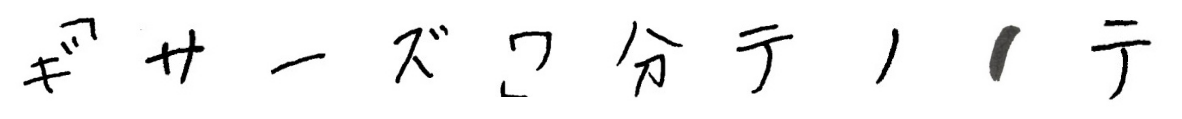

Cluster 1


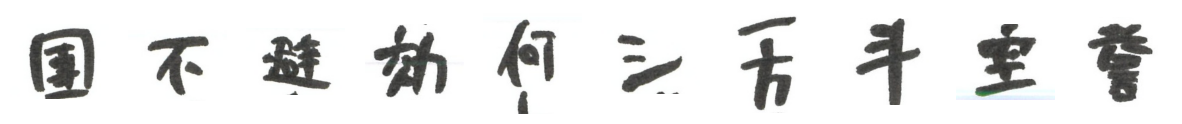

Cluster 2


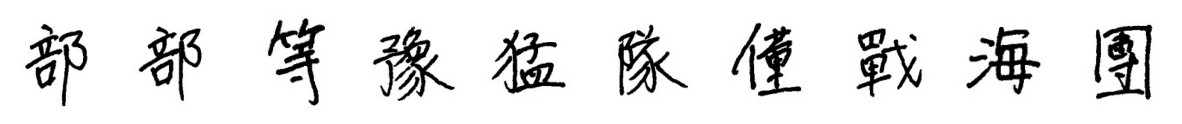

In [28]:
import matplotlib.pyplot as plt
import random

def plot_images_by_cluster(image_paths, labels, cluster_id):
    cluster_images = [img_path for img_path, label in zip(image_paths, labels) if label == cluster_id]
    num_images = min(len(cluster_images), 10)  # 每个聚类显示最多10张图片
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(random.sample(cluster_images, num_images)):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# 显示每个聚类中的图像
for cluster_id in range(num_clusters):
    print(f"Cluster {cluster_id}")
    plot_images_by_cluster(image_paths, image_labels, cluster_id)
